### Установка пакетов

Начнем с установки необходимых пакетов python. Ничего необычного не понадобится - numpy, cv2, matplotlib

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

Теперь можно импортировать

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from  random import randint
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

### Инициализация SLAM с использованием OpenCV (30 баллов)

Итак, мы снова находимся в сгенерированном мире c первой лекции. У нас был автомобиль, на котором были установлены сенсоры, выдающие нам карту глубин вместе с картинкой, а так же трансформацию (позу) в каждый момент времени. Теперь перейдем к более реальной ситуации: на нашей машине установлена только камера и ничего более (очень часто решается именно такая задача). Будем восстанавливать позу и глубины точек при помощи знаний, полученных на лекции (восстановление превой позы иногда называют инициализацией). Начнем с восстановления позы

Вам даны два изображения, вращение и перемещение между которыми мы хотим определить

In [2]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

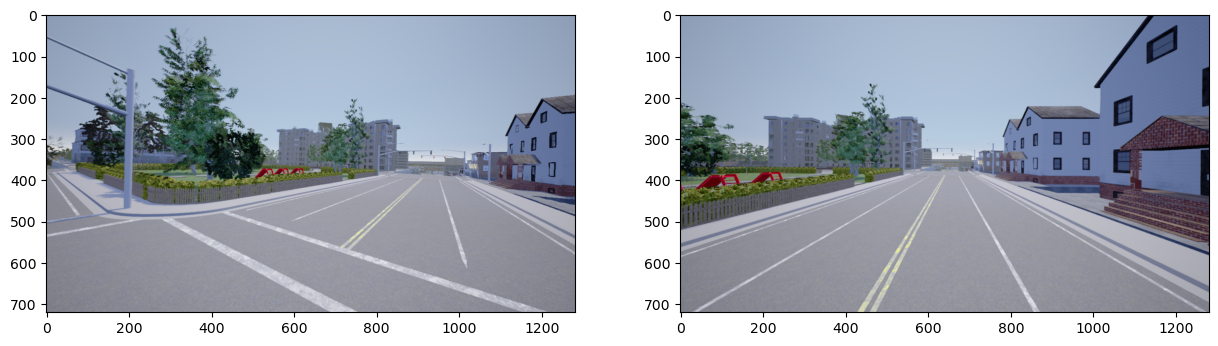

In [3]:
image1 = load_image("image1.png")
image2 = load_image("image2.png")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image1)
axarr[1].imshow(image2)

Как мы узнали на лекции, первое, что нужно сделать для восстановления позы - найти особые точки (фичи) на обоих изображениях и соответствие между ними (сматчить). На второй лекции вы уже научились это делать, поэтому не будем сильно заострять на этом внимание: найдите фичи и матчи любым способом, который вам понравился ([здесь](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) можете найти пример с SIFT фичами)

In [4]:
# Создайте детектер/матчер, найдите фичи, сматчите их, выделите лучшие

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1,None)
kp2, des2 = sift.detectAndCompute(image2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
pts1 = np.array(pts1)
pts2 = np.array(pts2)

Визуализируем наши матчи

In [5]:
def draw_matches(image_a: np.ndarray, image_b: np.ndarray, keypoints_a: np.ndarray, keypoints_b: np.ndarray):
    # initialize the output visualization image
    height_a, width_a = image_a.shape[:2]
    height_b, width_b = image_b.shape[:2]

    vis = np.zeros((max(height_a, height_b), width_a + width_b, 3), dtype="uint8")
    vis[0:height_a, 0:width_a] = image_a
    vis[0:height_b, width_a:] = image_b

    # loop over the matches
    for keypoint_a, keypoint_b in zip(keypoints_a, keypoints_b):
        # draw the match
        point_a = (int(keypoint_a[0]), int(keypoint_a[1]))
        point_b = (
            int(keypoint_b[0]) + width_a,
            int(keypoint_b[1]),
        )
        cv2.line(vis,
                 point_a,
                 point_b,
                 (randint(0, 255), randint(0, 255), randint(0, 255)), 1)

    # return the visualization
    return vis

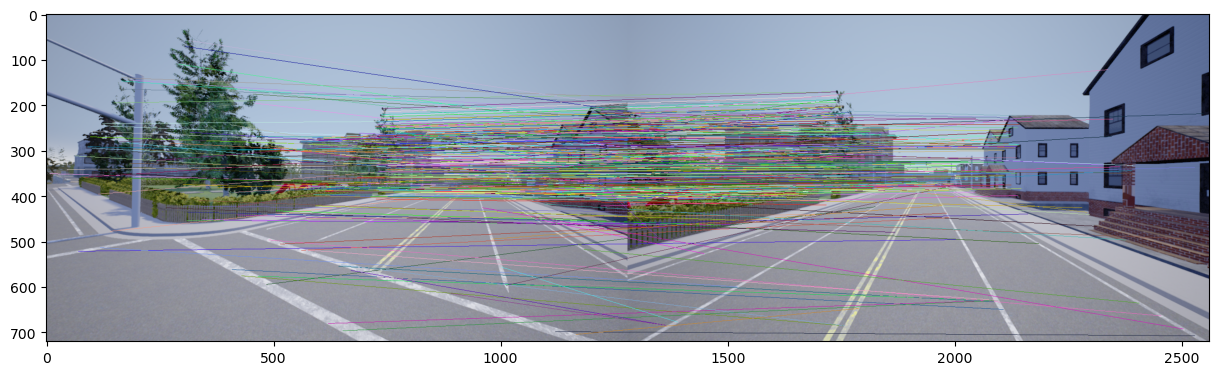

(<matplotlib.image.AxesImage at 0x7f1e51212c70>, None)

In [6]:
img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Итак, у нас есть матчи. Начнем с простого - воспользуемся встроенной функцией в OpenCV для определения существенной матрицы. Смотрите референс [здесь](https://amroamroamro.github.io/mexopencv/matlab/cv.findEssentialMat.html). Вам нужно правильно определить матрицу камеры и передать точки с левого и правого изображения.

In [117]:
fx = 448.1551643293023
fy = 448.1551643293023
px = 640.0
py = 360.0

K = np.eye(3)
K[0, 0] = fx
K[1, 1] = fy
K[0, 2] = px
K[1, 2] = py
E, mask = cv2.findEssentialMat(points1=pts1, points2=pts2, cameraMatrix=K)

Отлично, у нас есть существенная матрица E, а также некторая маска mask. Это маска показывает, какие из матчей у нас соответствуют полученной матрице (inliers), а какие нет (outliers).

In [9]:
pts1_inliers = pts1[mask.ravel()==1] # Numpy матрица Mx2 - координаты инлайеров на левом изображении
pts2_inliers = pts2[mask.ravel()==1] # Numpy матрица Mx2 - координаты инлайеров на правом изображении

Визуализиреум инлайеры и посмотрим, какой процент точек оказался инлайерами. Чем процент больше, тем лучше был наш матчер. Нормально, если он будет около 50%.

Процент инлайеров: 54.26136363636363%


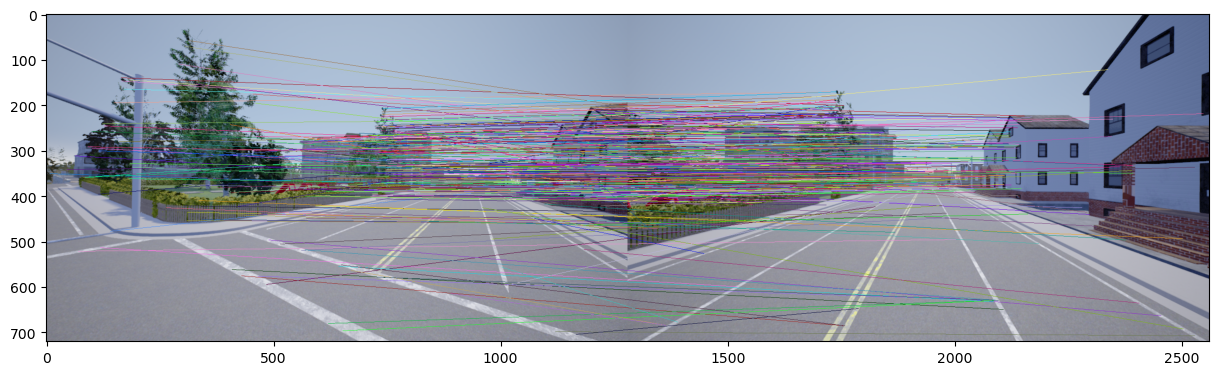

(<matplotlib.image.AxesImage at 0x7f1e5119a1f0>, None)

In [10]:
print(f"Процент инлайеров: {pts1_inliers.shape[0] / pts1.shape[0] * 100}%")

img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Если визуально корреспонденсы между изображениями выглядят адекватно, то самое время восстанавливать позу из существенной матрицы. Сейчас воспользуемся для этого внутренней функцией OpenCV - recoverPose. Не забудьте использовать для это только инлайеры!

In [11]:
numOfInliers, R_opencv, t_opencv, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K) # Воостановите позу из E с помощью recoverPose

Отлично, у нас есть оцененные R и t. Самое время сравнить его с ground truth (gt), который нам был дан в первом задании. Есть один нюанс: на лекции мы узнали, что из алгоритмов такого рода нельзя восстановить скейл сцены, поэтому перед сравнением t_gt нужно нормализовать.

In [12]:
R_gt = np.array([[8.50318515e-01, 2.07742095e-02, -5.25858208e-01],
              [-2.47312245e-02, 9.99694013e-01, -4.97406376e-04],
              [5.25686969e-01, 1.34280713e-02, 8.50572100e-01]])
t_gt = np.array([[6.51715996e-01, 6.20712517e-03, -6.44666629e+00]]).transpose()
scale = np.linalg.norm(t_gt)
t_gt /= scale

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_opencv) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_opencv) / np.linalg.norm(t_gt) * 100}%")

Ошибка в матрице вращения: 0.24050203685769692%
Ошибка в перемещении: 3.004391135063227%


Ошибиться на 1% во вращении и на 3% в перемещении - это нормально, хороший результат.

И последний этап с использованием готовых функций: восстановим глубины фич. Для этого нужно воспользоваться функцией triangulatePoints из библиотеки OpenCV. У нее чуть более хитрые входные данные, составим их поэтапно. Подумайте над тем, какую именно позу мы нашли (R_opencv, t_opencv), и какие позы у первого и второго изображения.

In [13]:
# проективная матрица для первого изображения. Напоминаем, что проективная матрица это
# CameraMatrix @ np.eye(3, 4) @ PoseMatrix4x4
projection_matrix_1 = K @ np.eye(3, 4)
# проективная матрица для второго изображения. Напоминаем, что проективная матрица это
# CameraMatrix @ np.eye(3, 4) @ PoseMatrix4x4
projection_matrix_2 = K @ np.hstack([R_opencv, t_opencv])

# триангулируйте точки с помощью triangulatePoints. Это будут 3D точки в однородных координатах
points_3d_hom = cv2.triangulatePoints(
    projection_matrix_1,
    projection_matrix_2,
    pts1_inliers.T,
    pts2_inliers.T
)
# превратите 3D из однородных координат в обычные
points_3d = (points_3d_hom[:3, :] / points_3d_hom[3, :]).T
# получите глубины из данных 3D точек. Это делжен быть вектор длиной M (количество инлайеров).
depth_opencv = points_3d[:, 2]

Самое время загрузить глубины, которые были даны в первом ДЗ и сравнить с полученными. Опять же, не забудьте, что глубины точек метрические, а значит зависят от скейла. Мы уже зафиксировали скейл для gt, поэтому воспользуемся им.

In [15]:
# Загрузим gt глубины, нормируем их
depth_gt_full = np.load("depth1.npy") * 1000 / scale
# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

# Посчитаем среднюю ошибку. Не будем учитывать слишком далекие точки
errors = []
for i, d_gt in enumerate(depth_gt):
    if d_gt < 100 / scale:
        errors.append(abs(d_gt - depth_opencv[i]) / max(d_gt, depth_opencv[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}%")

Средняя ошибка в определении глубин: 8.027758712765232%


Отлично, ошибиться на 10% в определении глубин - это нормально, на это влияет много факторов.

Итак мы продедади полную инициализацию SLAM - нашли матчи, посчитали существенную матрицу, восстановили позу и глубины. На этом задача заверщается и далее предлалагается продлелать те же вещи, но написать все алгоритмы самостоятельно

### Инициализация SLAM с использованием самописных методов (20 баллов)

Начнем опять с восстановления существенной матрицы. Не забудьте, что на вход мы подаем изначальные точки, pts1 и pts2

In [111]:
# Тут можно сильно оптимизировать, если заранее все точки превратить в лучи, а потом в RANSAC
# выбирать набор из 8ми лучей, а не точек, но а учебных целях мне показалось 
# более правильно создачать лучи внутри findEssentialMatrix8pt, так функция становится более замкнутой

def findEssentialMatrix8pt(pts1_8pt, pts2_8pt, K):
    # В данный функции реализуйте 8 points алгоритм для определения существенной матрицы
    # В качестве сингулярных чисел используйте сразу [1, 1, 0]
    assert ((pts1_8pt.shape[0] == 8) and ((pts2_8pt.shape[0] == 8)))
    rays_1 = np.linalg.inv(K) @ np.vstack((pts1_8pt.T, np.ones((1, 8))))
    rays_2 = np.linalg.inv(K) @ np.vstack((pts2_8pt.T, np.ones((1, 8))))
    A = np.zeros((8, 9))
    for i in range(8):
        x1, y1, z1 = rays_1[:, i]
        x2, y2, z2 = rays_2[:, i]
        A[i] = [x1 * x2, x1 * y2, x1 * z2, y1 * x2, y1 * y2, y1 * z2, z1 * x2, z1 * y2, z1 * z2]

    _, _, V = np.linalg.svd(A)
    E = V[-1].reshape((3, 3)).T

    u_E, _, vh_E = np.linalg.svd(E, full_matrices=True)
    E_final = u_E @ np.diag(np.array([1, 1, 0])) @ vh_E

    return E_final

def findEssentialMatrixRansac(pts1, pts2,
                              K,
                              samples=3000, threshold=0.0001):
    # В данный функции реализуйте RANSAC, который будет случайно выбирать 8 точек, определять по ним E,
    # считать, сколько инлайеров соответствет данной модели (инлайер - та пара, у которой epipolar constraint
    # меньше threshold). И так samples раз. Верните E, у которой максимальное количество инлайеров. Так
    # же верните маску mask, как \то делает OpenCV
    best_inliers = []
    best_E = np.empty((3, 3))
    for j in range(samples):
        # Выделить 8 случайных пар
        points_indices = np.random.choice(pts1.shape[0], 8, replace=False)
        points1_batch = pts1[points_indices]
        points2_batch = pts2[points_indices]
        # Оценить сузественную матрицу
        E = findEssentialMatrix8pt(points1_batch, points2_batch, K)
        # Проверить, сколько инлайеров у модели
        inliers = []
        rays1 = (np.linalg.inv(K) @ np.vstack((pts1.T, np.ones((1, pts1.shape[0]))))).T
        rays2 = (np.linalg.inv(K) @ np.vstack((pts2.T, np.ones((1, pts2.shape[0]))))).T
        for i in range(len(rays1)):
            x1 = rays1[i]
            x2 = rays2[i]
            epipolar_constraint = np.abs(x2.T @ E @ x1)
            if epipolar_constraint < threshold:
                inliers.append(i)

        if len(inliers) > len(best_inliers):
            best_E = E
            best_inliers = inliers
    mask = np.zeros(len(pts1), dtype=bool)
    mask[best_inliers] = True
    return best_E, mask

Воспользуйтесь новой функцией, определите существенную матрицу и вновь определите инлайеры

In [112]:
E_est, mask_est = findEssentialMatrixRansac(pts1, pts2, K)
pts1_inliers = pts1[mask_est.ravel()==1] # Numpy матрица Mx2 - координаты инлайеров на левом изображении
pts2_inliers = pts2[mask_est.ravel()==1] # Numpy матрица Mx2 - координаты инлайеров на правом изображении

Сравните визульно E (определена с помощью OpenCV) и E_est (определена вручную). Если есть небольшие отличия - это не страшно, иметь смысл будет только восстановленная поза.

In [113]:
print("OpenCV существенная матрица")
print(E)
print("Custom существенная матрица")
print(E_est)

OpenCV существенная матрица
[[ 0.01849734 -0.70503829  0.00436654]
 [ 0.62708382  0.0141072  -0.32641473]
 [-0.00267918 -0.05066711  0.00239854]]
Custom существенная матрица
[[ 0.01932684 -0.99415638 -0.00382497]
 [ 0.90025135  0.01997664 -0.43484706]
 [ 0.00886699 -0.10596759 -0.00369481]]


Далее напишите кастомную функцию для восстановления позы из существенной матрицы

In [140]:
def recoverPose(E, pts1, pts2, K):
    # Восстановите позу из E. Из 4х гипотез выберите ту, у которой точек перед камерой больше всего.
    # Считайте, что перед камерой - это значит глубина > 1
    # Верните из этой функции R и t по отдельности
    u_E, s_E, vh_E = np.linalg.svd(E, full_matrices=True)
    # Иногда вместо поворов получаются отражения
    u_E = np.linalg.det(u_E) * u_E
    vh_E = np.linalg.det(vh_E) * vh_E
    
    pi_2 = np.array(
        [[0, -1, 0],
         [1, 0, 0],
         [0, 0, 1]])
    minus_pi_2 = np.array(
        [[0, 1, 0],
         [-1, 0, 0],
         [0, 0, 1]])
    R1 = u_E @ pi_2.T @ vh_E
    R2 = u_E @ minus_pi_2.T @ vh_E
    
    t1 = (u_E @ pi_2 @ np.diag(s_E) @ u_E.T)
    t1 = np.array([t1[2, 1], -t1[2, 0], t1[1, 0]]).reshape((3, 1))

    t2 = (u_E @ minus_pi_2 @ np.diag(s_E) @ u_E.T)
    t2 = np.array([t2[2, 1], -t2[2, 0], t2[1, 0]]).reshape((3, 1))

    proj_1 = K @ np.eye(3, 4)

    T_hypothesis = []
    T_hypothesis.append(np.hstack((R1, t1)))
    T_hypothesis.append(np.hstack((R1, t2)))
    T_hypothesis.append(np.hstack((R2, t1)))
    T_hypothesis.append(np.hstack((R2, t2)))

    best_T = T_hypothesis[0]
    bestInliers = 0
    for T_mat in T_hypothesis:
        proj_2 = K @ T_mat
        points_3d_hom = cv2.triangulatePoints(proj_1, proj_2, pts1.T, pts2.T)
        points_3d = (points_3d_hom[:3, :] / points_3d_hom[3, :]).T
        
        depth_opencv = points_3d[:, 2]
        inliers = np.sum(depth_opencv >= 1)

        if inliers > bestInliers:
            best_T = T_mat
            bestInliers = inliers
    return best_T[:, :3], best_T[:, 3:4]

Воспользуйтесь новой функцией, восстановите позу и сравните ее с gt. Больше или меньше ошибка, по сравнении с методом из OpenCV?

In [141]:
R_custom, t_custom = recoverPose(E_est, pts1_inliers, pts2_inliers, K)

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_custom) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_custom) / np.linalg.norm(t_gt) * 100}%")

Ошибка в матрице вращения: 0.2859419904034916%
Ошибка в перемещении: 0.8615422880036397%


In [142]:
def hat(vec):
    return np.array([[0, -vec[2], vec[1]], [vec[2], 0, -vec[0]], [-vec[1], vec[0], 0]])

def triangulatePoints(pts1, pts2, R, t, K):
    # Реализуйте триангуляцию, аналогичную OpenCV.
    # Не надо заморачиваться с 3D точками - возвращайте сразу вектор Mx1, где M - количество точек на входе
    rays_1 = np.dot(np.linalg.inv(K), np.hstack([pts1, np.ones((pts1.shape[0], 1))]).T).T
    rays_2 = np.dot(np.linalg.inv(K), np.hstack([pts2, np.ones((pts2.shape[0], 1))]).T).T
    n = rays_1.shape[0]
    A = np.zeros((n * 3, n+1))
    # diagonal
    for i in range(n):
        A[3 * i: 3 * i + 3, i:i+1] = hat(rays_2[i]) @ R @ rays_1[i:i+1, :].T
    # last column
    for i in range(n):
        A[3 * i: 3 * i + 3, n:n+1] = hat(rays_2[i]) @ t

    # find solution
    _, _, vh = np.linalg.svd(A, full_matrices=True)
    depths = vh[-1]
    # divide on inner scale
    depths = depths[:n] / depths[n]
    # divide on translation scale
    depths /= np.linalg.norm(t)

    return depths

Зделаем аналогичноное сравнение с gt. Опять же, ошибаться в пределе 10-20% - это хороший результат.

In [143]:
depth_custom = triangulatePoints(
    pts1_inliers,
    pts2_inliers,
    R_custom, t_custom, K
)

# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

errors = []
for i, d_gt in enumerate(depth_gt):
    if d_gt < 100 / scale:
        errors.append(abs(d_gt - depth_custom[i]) / max(d_gt, depth_custom[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}")

Средняя ошибка в определении глубин: 13.456596695000663
